In [1]:
# TODO
# Change name to include Fig S1
# Make function to plot aggregated evolving contours and store files
# Modify find contours function to achieve less than 10% of contours intersecting with buffer
# Import/read ATL11 (try h5coro)
# Add ATL11 overlay
# Add something along the lines of code below to illustrate lake area/outline:
# # Plot polygons in the GeoDataFrame
# gdf.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=1, label='Polygon Area')

# # Optionally, if you want to plot just the boundaries with a different style
# gdf.boundary.plot(ax=ax, color='red', linewidth=2, label='Polygon Boundary')

# Set up computing environment

In [1]:
%pip install openpyxl

  Using cached openpyxl-3.1.2-py2.py3-none-any.whl (249 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import libraries
import datetime
import earthaccess
import geopandas as gpd
import matplotlib
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
import matplotlib.colors as colors
import matplotlib.dates as mdates
from matplotlib.legend_handler import HandlerTuple
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import os
from os import path
from pyproj import CRS, Transformer
import rioxarray
from rioxarray.exceptions import NoDataInBounds
from shapely.geometry import box, Polygon
from shapely.ops import unary_union
from skimage import measure
import xarray as xr

# Define data directories dependent on home environment
# Replace with your directory file paths
if os.getenv('HOME') == '/home/jovyan':
    DATA_DIR = '/home/jovyan/data'
    SCRIPT_DIR = '/home/jovyan/repos_my/script_dir'
    OUTPUT_DIR = '/home/jovyan/1_outlines_candidates/output/Fig2_lake_reexamination.ipynb'

# Define constants and coordinate transforms for the geodesic area calculation
CRS_LL = "EPSG:4326" # wgs84 in lon,lat
GEOD = CRS(CRS_LL).get_geod() # geod object for calculating geodesic area on defined ellipsoid
CRS_XY = "EPSG:3031" # Antarctic Polar Stereographic in x, y
XY_TO_LL = Transformer.from_crs(CRS_XY, CRS_LL, always_xy = True) # make coord transformer

# Change default font to increase font size
plt.rcParams.update({'font.size': 12})

# Functions

In [4]:
def read_field(group, field):
    """
    generic field-reading function
    """
    data=np.array(group[field])
    bad=(data==group[field].attrs['_FillValue'])
    data[bad]=np.NaN
    return data

In [5]:
def read_ATL11(filename, pair):
    """
    ATL11 reader
    """
    with h5py.File(filename,'r') as h5f:
        longitude=read_field(h5f[pair],'longitude')
        latitude=read_field(h5f[pair],'latitude')
        h_corr=read_field(h5f[pair],'h_corr')
        h_corr_sigma=read_field(h5f[pair],'h_corr_sigma')
        h_corr_sigma_s=read_field(h5f[pair],'h_corr_sigma_systematic')
        quality=np.array(h5f[pair]['quality_summary'])
    for col in range(h_corr.shape[1]):
        h_corr[quality==1]=np.NaN
    # return the values
    return longitude, latitude, h_corr, np.sqrt(h_corr_sigma**2+h_corr_sigma_s**2)

In [9]:
def datetime64_to_fractional_year(date):
    """
    Convert a numpy.datetime64 object into a fractional year, rounded to 0, .25, .5, or .75.
    """
    year = date.astype('datetime64[Y]').astype(int) + 1970
    start_of_year = np.datetime64(f'{year}-01-01')
    start_of_next_year = np.datetime64(f'{year + 1}-01-01')
    year_length = (start_of_next_year - start_of_year).astype('timedelta64[D]').astype(int)
    day_of_year = (date - start_of_year).astype('timedelta64[D]').astype(int)
    fractional_year = year + day_of_year / year_length

    # Round to nearest quarter
    rounded_fractional_year = round(fractional_year * 4) / 4
    return rounded_fractional_year

# # Example usage
# date = np.datetime64('2024-01-05')
# fractional_year = datetime64_to_fractional_year(date)

In [10]:
def date_to_fractional_year(date):
    """
    Convert a datetime.date or datetime.datetime object into a fractional year
    """
    year = date.year
    start_of_year = datetime.date(year, 1, 1)
    start_of_next_year = datetime.date(year + 1, 1, 1)
    year_length = (start_of_next_year - start_of_year).days
    day_of_year = (date - start_of_year).days
    fractional_year = year + day_of_year / year_length
    return fractional_year

# # Example usage with a datetime.date object
# date = datetime.date(2024, 1, 5)
# fractional_year = date_to_fractional_year(date)
# fractional_year

In [4]:
def convert_to_2d(geometry):
    '''
    Converts 3D geometric objects to their 2D representation.

    This function processes input geometries and converts them into 2D forms. 
    It supports 'Polygon' and 'MultiPolygon' geometries. For 'Polygon' types, 
    it flattens the geometry to 2D by ignoring the z-coordinate. For 
    'MultiPolygon' types, it applies this flattening to each polygon in the 
    collection. If the input geometry is neither 'Polygon' nor 'MultiPolygon', 
    the function raises a ValueError.

    Parameters:
    geometry (shapely.geometry): The geometry object to be converted. This 
                                 should be an instance of either Polygon or 
                                 MultiPolygon from the shapely.geometry module.

    Returns:
    shapely.geometry.Polygon: If the input is a 'Polygon'.
    shapely.geometry.MultiPolygon: If the input is a 'MultiPolygon'.

    Raises:
    ValueError: If the input geometry type is not supported (not a 'Polygon' or
                'MultiPolygon').
    '''
    if geometry.geom_type == 'Polygon':
        return Polygon([(x, y) for x, y, z in geometry.exterior.coords])
    elif geometry.geom_type == 'MultiPolygon':
        return MultiPolygon([Polygon([(x, y) for x, y, z in poly.exterior.coords]) for poly in geometry])
    else:
        raise ValueError(f"Unsupported geometry type: {geometry.geom_type}")
        
# Example:
# from shapely.geometry import Polygon, MultiPolygon
# polygon = Polygon([(0, 0, 1), (1, 0, 1), (1, 1, 1), (0, 1, 1)])
# convert_to_2d(polygon)

In [5]:
def find_intersections(gdf1, gdf2):
    # Create an empty list to store the results
    intersections = []

    # Iterate over each geometry in gdf1
    for index1, geom1 in gdf1.geometry.items():
        # Compare with each geometry in gdf2
        for index2, geom2 in gdf2.geometry.items():
            if geom1.intersects(geom2):
                # If they intersect, add the indices to the list
                intersections.append((index1, index2))

    return intersections

In [6]:
# def unify_polygons(polygons):
#     """
#     Unifies a list of polygons into a single polygon.

#     :param polygons: A list of polygon geometries.
#     :return: A unified polygon geometry.
#     """
#     if not polygons:
#         return None  # or raise an error if appropriate

#     # Extract the geometry values from the GeoSeries and put them in a list
#     geometry_list = [polygon.geometry.values for polygon in polygons]

#     # Use unary_union to handle the union of multiple geometries
#     # union_polygon = unary_union(geometry_list)
#     union_polygon = unary_union(geometry_list)

#     return union_polygon

# # # Create a list of polygons
# # polygons = [polygon1, polygon2, polygon3]

# # # Get the unified polygon
# # unified_polygon = unify_polygons(polygons)

In [7]:
def unify_polygons(polygons):
    """
    Unifies a list of polygons into a single polygon.

    :param polygons: A list of polygon geometries.
    :return: A unified polygon geometry.
    """
    if not polygons:
        return None  # or raise an error if appropriate

    # Extract the geometry values from the GeoSeries and put them in a list
    geometry_list = [polygon.geometry.values for polygon in polygons]

    # Use unary_union to handle the union of multiple geometries
    # union_polygon = unary_union(geometry_list)
    union_polygon = unary_union(geometry_list)
    
    # Convert to geodataframe
    union_polygon_gdf = gpd.GeoDataFrame({'geometry': [union_polygon]})
    
    # Set CRS
    union_polygon_gdf.geometry.crs = 'EPSG:3031'

    return union_polygon_gdf

# # Create a list of polygons
# polygons = [polygon1, polygon2, polygon3]

# # Get the unified polygon
# unified_polygon = unify_polygons(polygons)

In [8]:
# def muliple_area_buffer(polygon, area_multiple, precision=1):
#     """
#     This function takes a polygon and returns a polygon with a buffer such that the area of the buffered polygon
#     is approximately the specified multiple the area of the original polygon.

#     :param polygon: Shapely Polygon object
#     :param area_multiple: the multiple of the original polygon area you wish the buffered polygon to be
#     :param precision: Precision for the iterative process to find the buffer distance
#     :return: Buffered Polygon
#     """
#     original_area = polygon.area
#     target_area = area_multiple * original_area
#     buffer_distance = 0
#     buffered_polygon = polygon

#     while True:
#         buffered_polygon = polygon.buffer(buffer_distance)
#         if buffered_polygon.area >= target_area:
#             break
#         buffer_distance += precision

#     return buffered_polygon

# # # Example usage
# # # Define a simple square polygon
# # square = Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])

# # # Apply the function to find the buffered polygon area and bounds
# # buffered_poly = double_area_buffer(square)
# # buffered_poly.area, buffered_poly.bounds

In [9]:
def muliple_area_buffer(polygon, area_multiple, precision=1):
    """
    This function takes a polygon and returns a polygon with a buffer such that the area of the buffered polygon
    is approximately the specified multiple the area of the original polygon.

    :param polygon: Shapely Polygon object
    :param area_multiple: the multiple of the original polygon area you wish the buffered polygon to be
    :param precision: Precision for the iterative process to find the buffer distance
    :return: Buffered Polygon
    """
    original_area = polygon.area
    target_area = area_multiple * original_area
    buffer_distance = 0
    buffered_polygon = polygon

    while True:
        buffered_polygon = polygon.buffer(buffer_distance)
        if buffered_polygon.area >= target_area:
            break
        buffer_distance += precision
    
    # Convert to geodataframe
    buffered_polygon_gdf = gpd.GeoDataFrame({'geometry': [buffered_polygon]})
    
    # Set CRS
    buffered_polygon_gdf.geometry.crs = 'EPSG:3031'

    return buffered_polygon_gdf

# # Example usage
# # Define a simple square polygon
# square = Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])

# # Apply the function to find the buffered polygon area and bounds
# buffered_poly = double_area_buffer(square)
# buffered_poly.area, buffered_poly.bounds

In [10]:
def create_folder(directory):
    # Check if the directory already exists
    if not os.path.exists(directory):
        # If it doesn't exist, create a new directory
        os.makedirs(directory)
        print(f"Folder '{directory}' created successfully.")
    else:
        print(f"Folder '{directory}' already exists.")

In [12]:
# def find_bounds_shapely(polygon):
#     """
#     Find the bounding coordinates (xmin, xmax, ymin, ymax) of a Shapely Polygon.

#     :param polygon: Shapely Polygon object
#     :return: Tuple containing (xmin, xmax, ymin, ymax)
#     """
#     xmin, ymin, xmax, ymax = polygon.bounds
#     return xmin, xmax, ymin, ymax

# # # Example usage
# # # Define a polygon using Shapely
# # polygon = Polygon([(1, 2), (3, 4), (5, 0), (-1, -3)])
# # # Get the bounds
# # bounds = find_bounds_shapely(polygon)
# # print(f"xmin: {bounds[0]}, xmax: {bounds[1]}, ymin: {bounds[2]}, ymax: {bounds[3]}")

In [126]:
def height_change_time_series(lake_gdf, dataset1, dataset2): 
    '''
    Create planview dh/dt plots of ice surface height changes 
    
    Inputs:
    * ROI_name: str of the region of interest for using in file name saving
    * ROI_poly: list of polygon(s) that define evolving outline search extent
    * dataset1: dataset1 to be analyzed
    * dataset2: dataset2 to be analyzed in conjunction with dataset1; currently configured to 
    splice CryoSat-2 and ICESat-2 eras
    
    Outputs: 
    * Sequence of planview delta height visuals of ICESat-2 ATL15
    '''
    # Define lake name and polygon
    lake_name = lake_gdf.name[0]
    lake_poly = lake_gdf.iloc[0].geometry
    
    # Create buffered polygons for various multiples of lake area to find which
    # best emcompasses the height change signals at previously identified lakes
    buffered_poly_2x = muliple_area_buffer(lake_poly, 2)
    buffered_poly_3x = muliple_area_buffer(lake_poly, 3)
    buffered_poly_4x = muliple_area_buffer(lake_poly, 4)
    buffered_poly_5x = muliple_area_buffer(lake_poly, 5)

    # Clipping datasets
    dataset1_clipped = dataset1.rio.clip(buffered_poly_5x.geometry, dataset1.rio.crs)
    dataset2_clipped = dataset2.rio.clip(buffered_poly_5x.geometry, dataset2.rio.crs)

    # Establish x_min, x_max, y_min, y_max, 
    x_min, y_min, x_max, y_max = buffered_poly_5x.iloc[0].geometry.bounds
    x_buffer = abs(x_max-x_min)*0.1
    y_buffer = abs(y_max-y_min)*0.1
   
    # Make output folders
    create_folder(OUTPUT_DIR + '/{}'.format('height_change_time_series'))
    create_folder(OUTPUT_DIR + '/height_change_time_series/{}'.format(lake_name))
    print('Now creating/saving plots...')

    # Create lines for legend
    S09_color = 'cyan'
    SF18_color  = 'darkcyan'
    S24_color = 'deepskyblue'
    Smith2009 = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 5)), linewidth=2)
    SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color=SF18_color, linestyle=(0, (1, 3)), linewidth=2)
    Sauthoff2024 = plt.Line2D((0, 1), (0, 0), color=S24_color, linestyle=(0, (1, 1)), linewidth=2)

    # Calculate cycle-to-cycle dHeight at each cycle of the spliced data sets
    for idx in range(len(midcyc_dates)):
        # For midcyc_dates indexes <= 32, use CryoSat-2 dataset for cycle-to-cycle dHeight
        # This covers the CryoSat-2 era before ICESat-2 launch (2010-08-17 to 2018-08-17)
        if idx <= 32:
            dhdt_clipped = dataset1_clipped.delta_h[idx+1,:,:]-dataset1_clipped.delta_h[idx,:,:]
            dhdt_clipped.rio.write_crs("epsg:3031", inplace=True)

        # For midcyc_dates indexes > 32, use ICESat-2 dataset for cycle-to-cycle dHeight
        # This covers the ICESat-2 era (2018-11-16 to most recently available data)
        elif idx > 32:
            # Subtract 32 from idx to start over with new dataset
            dhdt_clipped = dataset2_clipped.delta_h[(idx-33)+1,:,:]-dataset2_clipped.delta_h[idx-33,:,:]
            dhdt_clipped.rio.write_crs("epsg:3031", inplace=True)
          
        # Only plot arrays that have data in them; some time slices have no data because no CryoSat-2 SARIn coverage
        # Returns True if there is at least one non-NaN value in data_stacked, and False if all values are NaN
        if np.any(~np.isnan(dhdt_clipped)):
            # Create fig, ax
            fig, ax = plt.subplots()

            # Plot figure
            img = ax.imshow(dhdt_clipped, extent=[x_min, x_max, y_min, y_max], 
                origin='lower', cmap='coolwarm_r', 
                norm=colors.CenteredNorm())

            # Plot buffered polygons
            buffered_poly_2x.boundary.plot(ax=ax, edgecolor='k', facecolor='none', linewidth=0.5)
            buffered_poly_3x.boundary.plot(ax=ax, edgecolor='k', facecolor='none', linewidth=0.5)
            buffered_poly_4x.boundary.plot(ax=ax, edgecolor='k', facecolor='none', linewidth=0.5)
            buffered_poly_5x.boundary.plot(ax=ax, edgecolor='k', facecolor='none', linewidth=0.5)
            
            # Overlay published active lake outlines for visual comparison and grounding line
            # Smith2009_outlines.boundary.plot(ax=ax, facecolor=S09_color, linestyle=(0, (1, 10)), linewidth=2, alpha=0.25)
            Smith2009_outlines.boundary.plot(ax=ax, edgecolor=S09_color, linestyle=(0, (1, 5)), linewidth=2)
            # SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, facecolor=SF18_color, linestyle=(0, (1, 5)), linewidth=2, alpha=0.25)
            print(len(SiegfriedFricker2018_SF18outlines))
            SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor=SF18_color, linestyle=(0, (1, 3)), linewidth=2)
            # Sauthoff2023_S23outlines.boundary.plot(ax=ax, facecolor=S23_color, linestyle=(0, (1, 1)), linewidth=2, alpha=0.25)
            # Sauthoff2024_S24outlines.boundary.plot(ax=ax, edgecolor=S24_color, linestyle=(0, (1, 1)), linewidth=2)

            # Change polar stereographic m to km
            km_scale = 1e3
            ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
            ax.xaxis.set_major_formatter(ticks_x)
            ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
            ax.yaxis.set_major_formatter(ticks_y)  

            # Label axes, set limits, and set title
            ax.set_xlabel('x [km]', size=15)
            ax.set_ylabel('y [km]', size=15) 
            ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))

            # Plot inset map
            axIns = ax.inset_axes([-0.01, 0.01, 0.3, 0.3]) # [left, bottom, width, height] (fractional axes coordinates)
            axIns.set_aspect('equal')
            moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
            moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
            axIns.axis('off')

            # # Plot black rectangle to indicate location
            # rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='k', zorder=3)
            # axIns.add_artist(rect)

            # Plot red star to indicate location
            axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
                linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)

            # Add colorbar 
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.2)
            fig.colorbar(img, cax=cax).set_label('height change (dh) [m]', size=15)

            # Add legend
            ax.legend([Smith2009, 
                       # SiegfriedFricker2018, 
                       # Sauthoff2024
                      ],
                ['static outline (S09)', 
                 # 'static outline (SF18)', 
                 # 'static point (S24)'
                ], 
                loc='upper center')
            
            # Save and close fig
            plt.savefig(OUTPUT_DIR + 
                '/height_change_time_series/{}/height_change_time_series_{}_{}-{}.png'
                .format(lake_name, lake_name, cyc_start_date.astype('datetime64[D]').astype(str), cyc_end_date.astype('datetime64[D]').astype(str)), dpi=300, bbox_inches='tight')
            plt.close()
    
# # Example usage
# find_evolving_outlines(ROI, threshold, dataset1, dataset2)

In [ ]:
    '''
    Make movie from stills in a folder
    '''

In [61]:
def find_evolving_outlines(ROI_name, ROI_poly, level, dataset1, dataset2): 
    '''
    Create planview dh/dt plots of ice surface height changes 
    Create time-variable outlines using skimage contour to plot evolving outlines as polygons.
    
    Inputs:
    * ROI_name: str of the region of interest for using in file name saving
    * ROI_poly: list of polygon(s) that define evolving outline search extent
    * level: vertical distance in meters to delineate ice surface deformation contour
    * dataset1: dataset1 to be analyzed
    * dataset2: dataset2 to be analyzed in conjunction with dataset1; currently configured to 
    splice CryoSat-2 and ICESat-2 eras
    
    Outputs: 
    * Sequence of planview delta height visuals of ICESat-2 ATL15 with variable ice surface 
    deformation contours plotted to delineate evolving lake boundaries.
    * geopandas geodataframe of polygons created at each step (would need to modify to collect all polygons 
    at all time steps)
    '''

    # Clipping datasets
    dataset1_clipped = dataset1.rio.clip(ROI_poly, dataset1.rio.crs)
    dataset2_clipped = dataset2.rio.clip(ROI_poly, dataset2.rio.crs)

    # Establish x_min, x_max, y_min, y_max, 
    # x_min, x_max, y_min, y_max = find_bounds_shapely(ROI_poly[0])
    x_min, x_max, y_min, y_max = ROI_poly[0].bounds

    # Create lines for legend
    uplift = plt.Line2D((0, 1), (0, 0), color='mediumblue', linestyle='dashdot', linewidth=2)
    subsidence = plt.Line2D((0, 1), (0, 0), color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)

    # Create empty list to store polygons, areas, perimeters and dates
    polys = []
    areas = []
    perims = []
    dhs = []
    dvols =[]
    midcyc_datetimes = []

    # Calculate cycle-to-cycle dHeight at each cycle of the spliced data sets
    for idx in range(len(midcyc_dates)):
        print(idx)
        # For midcyc_dates indexes <= 32, use CryoSat-2 dataset for cycle-to-cycle dHeight
        # This covers the CryoSat-2 era before ICESat-2 launch (2010-08-17 to 2018-08-17)
        if idx <= 33:
            dhdt_clipped = dataset1_clipped.delta_h[idx+1,:,:]-dataset1_clipped.delta_h[idx,:,:]
            print(dhdt_clipped.time)
            print(cyc_start_dates[idx])
            print(cyc_end_dates[idx])
            dhdt_clipped.rio.write_crs("epsg:3031", inplace=True)
            cyc_start_date = cyc_start_dates[idx]
            cyc_end_date = cyc_end_dates[idx]
            midcyc_date = midcyc_dates[idx]
        # For midcyc_dates indexes > 32, use ICESat-2 dataset for cycle-to-cycle dHeight
        # This covers the ICESat-2 era (2018-11-16 to most recently available data)
        elif idx > 33:
            # Subtract 33 from idx to start over with new dataset
            dhdt_clipped = dataset2_clipped.delta_h[idx+1,:,:]-dataset2_clipped.delta_h[idx,:,:]
            print(dhdt_clipped.time)
            print(cyc_start_dates[idx])
            print(cyc_end_dates[idx])
            # dhdt_subset = dataset2_subset.cyc_to_cyc_delta_h[(idx-33),:,:]
            dhdt_clipped.rio.write_crs("epsg:3031", inplace=True)
            # dhdt_subset.rio.write_crs("epsg:3031", inplace=True)
            cyc_start_date = cyc_start_dates[idx]
            cyc_end_date = cyc_end_dates[idx]
            midcyc_date = midcyc_dates[idx]
          
        # Create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt_clipped.shape[1]
        y_conv = (y_max-y_min)/dhdt_clipped.shape[0]

        # Only plot arrays that have data in them; some time slices have no data because no CryoSat-2 SARIn coverage
        # Returns True if there is at least one non-NaN value in data_stacked, and False if all values are NaN
        if np.any(~np.isnan(dhdt_clipped)):
            # Create fig, ax
            fig, ax = plt.subplots()

            # Plot figure
            img = ax.imshow(dhdt_clipped, extent=[x_min, x_max, y_min, y_max], 
                origin='lower', cmap='coolwarm_r', 
                norm=colors.CenteredNorm())

            gpd.GeoSeries(ROI_poly).boundary.plot(ax=ax)

            # Create empty lists to store contours 
            contours_pos = []
            contours_neg = []

            # Create contours at the positive and negative threshold 
            contour_pos = measure.find_contours(dhdt_clipped.values, level)
            # If at least one contour, add to list of contours
            if len(contour_pos) > 0: 
                contours_pos += [contour_pos]
            contour_neg = measure.find_contours(dhdt_clipped.values, -level)
            if len(contour_neg) > 0: 
                contours_neg += [contour_neg]

            # Plot contours and make into polygons
            for i in range(len(contours_pos)): 
                for j in range(len(contours_pos[i])):
                    x = x_min+contours_pos[i][j][:,1]*x_conv
                    y = y_min+contours_pos[i][j][:,0]*y_conv
                    ax.plot(x, y, color='mediumblue', linestyle='dashdot', linewidth=1, label=level)

                    # Make polygons from evolving outlines and store to list
                    if len(contours_pos[i][j][:,1]) > 2: 
                        poly = Polygon(list(zip(x, y)))
                        try:
                                dhdt_poly = dhdt_clipped.rio.clip([poly])
                                polys += [poly]
                                lon, lat = XY_TO_LL.transform(x,y)
                                poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])
                                areas += [poly_area]
                                poly_perim = abs(GEOD.polygon_area_perimeter(lon, lat)[1])
                                perims += [poly_perim]
                                poly_dh = np.nanmean(dhdt_poly)
                                dhs += [poly_dh]
                                poly_dvol = poly_dh*poly_area
                                dvols += [poly_dvol]
                                midcyc_datetimes += [midcyc_date]
                        except NoDataInBounds:
                            continue  # Skip to the next iteration
                        except Exception as e:
                            # Handle any other exceptions
                            raise

            for i in range(len(contours_neg)): 
                for j in range(len(contours_neg[i])):
                    x = x_min+contours_neg[i][j][:,1]*x_conv
                    y = y_min+contours_neg[i][j][:,0]*y_conv
                    ax.plot(x, y, color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=1, label=-level)

                    if len(contours_neg[i][j][:,1]) > 2: 
                        poly = Polygon(list(zip(x, y)))
                        try:
                                dhdt_poly = dhdt_clipped.rio.clip([poly])
                                polys += [poly]
                                lon, lat = XY_TO_LL.transform(x,y)
                                poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])
                                areas += [poly_area]
                                poly_perim = abs(GEOD.polygon_area_perimeter(lon, lat)[1])
                                perims += [poly_perim]
                                poly_dh = np.nanmean(dhdt_poly)
                                dhs += [poly_dh]
                                poly_dvol = poly_dh*poly_area
                                dvols += [poly_dvol]
                                midcyc_datetimes += [midcyc_date]
                        except NoDataInBounds:
                            continue  # Skip to the next iteration
                        except Exception as e:
                            # Handle any other exceptions
                            raise

            # Overlay published active lake outlines for visual comparison and grounding line
            S09_color = 'cyan'
            SF18_color  = 'darkcyan'
            S23_color = 'deepskyblue'
            # Smith2009_outlines.boundary.plot(ax=ax, facecolor=S09_color, linestyle=(0, (1, 10)), linewidth=2, alpha=0.25)
            Smith2009_outlines.boundary.plot(ax=ax, edgecolor=S09_color, linestyle=(0, (1, 10)), linewidth=2)
            # SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, facecolor=SF18_color, linestyle=(0, (1, 5)), linewidth=2, alpha=0.25)
            SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor=SF18_color, linestyle=(0, (1, 5)), linewidth=2)
            # Sauthoff2023_S23outlines.boundary.plot(ax=ax, facecolor=S23_color, linestyle=(0, (1, 1)), linewidth=2, alpha=0.25)
            Sauthoff2023_S23outlines.boundary.plot(ax=ax, edgecolor=S23_color, linestyle=(0, (1, 1)), linewidth=2)

            # Change polar stereographic m to km
            km_scale = 1e3
            ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
            ax.xaxis.set_major_formatter(ticks_x)
            ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
            ax.yaxis.set_major_formatter(ticks_y)  

            # Label axes, set limits, and set title
            ax.set_xlabel('x [km]', size=15)
            ax.set_ylabel('y [km]', size=15) 
            ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

            # Plot inset map
            axIns = ax.inset_axes([-0.01, 0.01, 0.3, 0.3]) # [left, bottom, width, height] (fractional axes coordinates)
            axIns.set_aspect('equal')
            moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
            moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
            axIns.axis('off')

            # # Plot black rectangle to indicate location
            # rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='k', zorder=3)
            # axIns.add_artist(rect)

            # Plot red star to indicate location
            axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
                linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)

            # Add colorbar 
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.2)
            fig.colorbar(img, cax=cax).set_label('height change (dh) [m]', size=15)

            # Add legend
            ax.legend([uplift, subsidence],
                [('+ '+str(threshold)+' m uplift (filling) evolving outline'), 
                 ('– '+str(threshold)+' m subsidence (draining) evolving outline')], 
                loc='upper left')

            # Save and close fig
            plt.savefig(OUTPUT_DIR + 
                '/{}/find_evolving_outlines_{}_{}m-level_{}-{}.png'
                .format(ROI_name, ROI_name, level, cyc_start_date.astype('datetime64[D]').astype(str), cyc_end_date.astype('datetime64[D]').astype(str)), dpi=300, bbox_inches='tight')
            plt.close()
    
    # Store polygons in geopandas geodataframe for further analysis
    d = {'geometry': polys, 
         'area (m^2)': areas, 
         'perim (m)': perims,
         'dh (m)': dhs, 
         'vol (m^3)': dvols, 
         'midcyc_datetime': midcyc_datetimes}
    gdf = gpd.GeoDataFrame(d, crs="EPSG:3031")
    gdf['centroid'] = gdf['geometry'].centroid
    gdf['midcyc_date'] = pd.to_datetime(gdf['midcyc_datetime']).apply(lambda x: x.date())

    return gdf

# # Example usage
# gdf = find_evolving_outlines(ROI, threshold, dataset1, dataset2)

In [20]:
def extract_intersecting_polygons(gdf, point):
    """
    Extract polygons from a GeoDataFrame that intersect with a specified point,
    as well as polygons that intersect with those intersected polygons.

    Parameters:
    gdf (geopandas.GeoDataFrame): A GeoDataFrame containing polygon geometries.
    point (shapely.Point): A shapely point

    Returns:
    geopandas.GeoDataFrame: A GeoDataFrame containing the polygons that either
                            intersect directly with the point or intersect with
                            polygons that intersect with the point.
    """
    # Create a point geometry
    point_geom = point.values[0]

    # Step 1: Find polygons that intersect with the given point
    intersecting_polygons = gdf[gdf.intersects(point_geom)]

    # Step 2: Find polygons that intersect with those found in step 1
    result_polygons = gdf[gdf.geometry.intersects(intersecting_polygons.unary_union)]

    return result_polygons

# Example usage
# gdf = geopandas.read_file("your_file.geojson")
# point = (x_coordinate, y_coordinate)
# result = extract_intersecting_polygons(gdf, point)

In [21]:
# def remove_outlier_polygon(gdf, axis='x', max_or_min='max'):
#     '''
#     Func to remove outline outliers by removing a polygon
#     with the most extreme x or y coordinates
    
#     Inputs
#     * geopandas geodataframe
#     * axis indicates whether the x or y axis will 
#     have its extreme polygon removed
#     * max_or_min indicates whether the max or min centroid axis
#     value will be removed
    
#     Ouputs
#     * geopandas geodataframe with one outline removed
#     '''
    
#     # Check if the GeoDataFrame is empty
#     if gdf.empty:
#         print("GeoDataFrame is empty. Nothing to remove.")
#         return gdf
    
#     # Choose the axis and max or min for extreme value
#     if axis not in ['x', 'y']:
#         raise ValueError("Invalid axis. Use 'x' or 'y'.")
#     if max_or_min not in ['max', 'min']:
#         raise ValueError("Invalid max_or_min. Use 'max' or 'min'.")

#     # Calculate the centroid and extreme value
#     if axis == 'x':
#         if max_or_min == 'max':
#             idx_to_remove = gdf.geometry.bounds['maxx'].idxmax()
#         else:
#             idx_to_remove = gdf.geometry.bounds['minx'].idxmin()
#     else:
#         if max_or_min == 'max':
#             idx_to_remove = gdf.geometry.bounds['maxy'].idxmax()
#         else:
#             idx_to_remove = gdf.geometry.bounds['miny'].idxmin()

#     # Remove the polygon with the specified polygon index to remove
#     gdf_filtered = gdf.drop(idx_to_remove)

#     print(f"Removed polygon with extreme {max_or_min} {axis}-value at index {idx_to_remove}.")

#     return gdf_filtered

# # Example usage:
# # Assuming 'gdf' is your GeoDataFrame
# # new_gdf = remove_extreme_polygon(gdf, axis='x', positive=True)

In [22]:
# Func to plot aggregate evolving outlines


# Import datasets

In [120]:
# Import subglacial lake outlines 
exec(open(SCRIPT_DIR + '/Sauthoff2024_outlines.py').read())

In [15]:
# MODIS MOA 2014 coastline and grounding line
# https://nsidc.org/data/nsidc-0730/versions/1
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_coastline_v01.shp' 
moa_2014_coastline = gpd.read_file(shp)
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_grounding_line_v01.shp' 
moa_2014_groundingline = gpd.read_file(shp, crs=3031)
# moa_2014_groundingline['geometry'] = moa_2014_groundingline.buffer(0)

In [42]:
# Import Smith and others, 2017, TC method CryoSat-2 SARIn height and dheight data (closed source aquired from Ben Smith)
CS2_Smith2017 = xr.open_dataset(DATA_DIR + '/altimetry/CryoSat2/CS2_SARIn_Smith2017method/mos_2010.5_2019.0_relative_to_ATL14.nc')
CS2_Smith2017

<xarray.Dataset>
Dimensions:      (y: 4451, x: 5451, time: 34)
Coordinates:
  * y            (y) float64 -2.185e+06 -2.184e+06 ... 2.264e+06 2.265e+06
  * x            (x) float64 -2.665e+06 -2.664e+06 ... 2.784e+06 2.785e+06
  * time         (time) datetime64[ns] 2010-07-02T15:00:00 ... 2018-10-01T22:...
Data variables:
    mask         (y, x) float64 ...
    count        (time, y, x) float64 ...
    spatial_ref  int64 ...
    h            (time, y, x) float64 ...
    delta_h      (time, y, x) float64 ...
Attributes:
    fileName:                mos_2010.5_2021.5.h5
    shortName:               CS2-Smith-2017
    identifier_product_DOI:  doi:10.5194/tc-11-451-2017

In [17]:
CS2_Smith2017_count = CS2_Smith2017.where(CS2_Smith2017['count'] > 0.5)

In [18]:
# Experimenting with ATL11 read in

In [19]:
# Log into NASA Earthdata to search for datasets
earthaccess.login()

In [20]:
# # Find ICESat-2 ATL11 r003 data granules
# results = earthaccess.search_data(
#     doi='10.5067/ATLAS/ATL11.006',
#     # short_name='ATL15',
#     # version='003',
#     bounding_box=(180, -90, -180, -60),  # (lower_left_lon, lower_left_lat , upper_right_lon, upper_right_lat))
#     cloud_hosted=True,
# )

In [21]:
# # Open data granules as s3 files to stream
# files = earthaccess.open(results)
# # files

In [22]:
# files[1]

In [23]:
# import datatree as dt

# # Open the HDF5 file
# with h5py.File(files[0], 'r') as h5file:
#     # Load the entire HDF5 file into a DataTree
#     data_tree = dt.DataTree.from_hdf5(h5file)

# # Now `data_tree` is a DataTree object containing the structure and data of the HDF5 file
# # You can navigate and manipulate this tree structure as needed

# # For example, to print the contents of the DataTree
# print(data_tree)

In [24]:
# # create empty lists
# lon=[]
# lat=[]
# h_corr=[]
# sigma_h=[]

# # fill lists
# for file in files:
#     print(file)
#     try:
#         for pair in ['pt1','pt2','pt3']:
#             lons, lats, hh, ss=read_ATL11(file, pair)
#             lon += [lons]
#             lat += [lats]
#             h_corr += [hh]
#             sigma_h += [ss]
#     except Exception as E:
#         pass

# # concatenate lists
# lon=np.concatenate(lon)
# lat=np.concatenate(lat)
# h_corr=np.concatenate(h_corr, axis=0)
# sigma_h=np.concatenate(sigma_h, axis=0)
# x,y=ll2ps(lon,lat) # transform geodetic lon, lat to polar stereographic x, y

In [25]:
# Find ICESat-2 ATL15 r003 data granules
results = earthaccess.search_data(
    doi='10.5067/ATLAS/ATL15.003',
    # short_name='ATL15',
    # version='003',
    bounding_box=(180, -90, -180, -60),  # (lower_left_lon, lower_left_lat , upper_right_lon, upper_right_lat))
    cloud_hosted=True,
)

Granules found: 16


In [26]:
# Open data granules as s3 files to stream
files = earthaccess.open(results)
files

Opening 16 granules, approx size: 5.05 GB


QUEUEING TASKS | :   0%|          | 0/16 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/16 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/16 [00:00<?, ?it/s]

[<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_40km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_10km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_20km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_01km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A3_0318_20km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_20km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_40km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A

In [27]:
# After viewing files, index the files you wish to open
print(files[15])
print(files[3])
print(files[9])
print(files[11])

<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A1_0318_01km_003_01.nc>
<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_01km_003_01.nc>
<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A3_0318_01km_003_01.nc>
<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_01km_003_01.nc>


In [28]:
# Open each file, which are quadrants in polar stereographic coordinations around the Geographic South Pole
ATL15_A1 = xr.open_dataset(files[15], group='delta_h')
ATL15_A2 = xr.open_dataset(files[3], group='delta_h')
ATL15_A3 = xr.open_dataset(files[9], group='delta_h')
ATL15_A4 = xr.open_dataset(files[11], group='delta_h')

In [29]:
# Open locally stored files when NSIDC cloud access isn't working
ATL15_A1 = xr.open_dataset(DATA_DIR + '/altimetry/ICESat2/ATL15.003-Ant/ATL15_A1_0318_01km_003_01.nc', group='delta_h')
ATL15_A2 = xr.open_dataset(DATA_DIR + '/altimetry/ICESat2/ATL15.003-Ant/ATL15_A2_0318_01km_003_01.nc', group='delta_h')
ATL15_A3 = xr.open_dataset(DATA_DIR + '/altimetry/ICESat2/ATL15.003-Ant/ATL15_A3_0318_01km_003_01.nc', group='delta_h')
ATL15_A4 = xr.open_dataset(DATA_DIR + '/altimetry/ICESat2/ATL15.003-Ant/ATL15_A4_0318_01km_003_01.nc', group='delta_h')

In [30]:
# Specify the variables to keep
variables_to_keep = ['time', 'y', 'x', 'delta_h']

# List of xarray datasets
datasets = [ATL15_A1, ATL15_A2, ATL15_A3, ATL15_A4]

# Function to drop variables not in variables_to_keep from a dataset
def drop_unwanted_variables(dataset):
    variables_to_drop = [var for var in dataset.variables if var not in variables_to_keep]
    return dataset.drop_vars(variables_to_drop)

# Apply the function to each dataset
ATL15_A1, ATL15_A2, ATL15_A3, ATL15_A4 = [drop_unwanted_variables(ds) for ds in datasets]

In [31]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15_A12 = xr.concat([ATL15_A2.isel(x=slice(0,-1)), ATL15_A1], dim="x")

In [32]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15_A34 = xr.concat([ATL15_A3.isel(x=slice(0,-1)), ATL15_A4], dim='x')

In [33]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15_dh = xr.concat([ATL15_A34.isel(y=slice(0,-1)), ATL15_A12], dim='y')

In [34]:
# Delete variables to reduce memory consumption
del ATL15_A1, ATL15_A12, ATL15_A2, ATL15_A3, ATL15_A34, ATL15_A4

In [35]:
# Add datasets attributes
ATL15_dh.attrs['identifier_product_DOI'] = '10.5067/ATLAS/ATL15.003'
ATL15_dh.attrs['shortName'] = 'ATL15'

In [36]:
ATL15_dh

<xarray.Dataset>
Dimensions:  (time: 19, x: 5461, y: 4461)
Coordinates:
  * time     (time) datetime64[ns] 2018-10-01T22:30:00 ... 2023-04-02T13:30:00
  * x        (x) float64 -2.67e+06 -2.669e+06 -2.668e+06 ... 2.789e+06 2.79e+06
  * y        (y) float64 -2.19e+06 -2.189e+06 -2.188e+06 ... 2.269e+06 2.27e+06
Data variables:
    delta_h  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    description:             delta_h group includes variables describing heig...
    identifier_product_DOI:  10.5067/ATLAS/ATL15.003
    shortName:               ATL15

In [37]:
# Scripps Grounding Line
# https://doi.pangaea.de/10.1594/PANGAEA.819147
Scripps_gl = gpd.read_file(DATA_DIR + 
    '/boundaries/Depoorter2013/Antarctica_masks/scripps_antarctica_polygons_v1.shp')

# Isolate only land ice
Scripps_landice = Scripps_gl[Scripps_gl['Id_text'] == 'Grounded ice or land']

In [38]:
# Import MODIS Mosaic of Antarctica surface imagery
# https://nsidc.org/data/nsidc-0730/versions/1
# Relocate to data_dir
# Open into an xarray.DataArray
# moa_lowres = DATA_DIR + '/surface_imagery/MODIS_MOA/2014/moa750_2014_hp1_v01.tif' 
# moa_lowres_da = rioxarray.open_rasterio(moa_lowres)

moa_highres = DATA_DIR + '/surface_imagery/MODIS_MOA/2014/moa125_2014_hp1_v01.tif' 
moa_highres_da = rioxarray.open_rasterio(moa_highres)

Warning 1: TIFFReadDirectory:Invalid data type for tag StripByteCounts
Warning 1: TIFFFetchNormalTag:Incorrect value for "GeoKeyDirectory"; tag ignored
Warning 1: TIFFFetchNormalTag:ASCII value for tag "GeoASCIIParams" contains null byte in value; value incorrectly truncated during reading due to implementation limitations


# Pre-process data

In [45]:
# Clip altimetry datasets to grounding line to limit analysis to only below grounded ice
CS2_Smith2017.rio.write_crs(3031, inplace=True)
CS2_Smith2017 = CS2_Smith2017.rio.clip(Scripps_landice.geometry.values, Scripps_landice.crs, drop=False)
ATL15_dh.rio.write_crs("epsg:3031", inplace=True)
ATL15_dh = ATL15_dh.rio.clip(Scripps_landice.geometry.values, Scripps_landice.crs)

In [46]:
dataset1=CS2_Smith2017
dataset2=ATL15_dh

# Create empty lists to store data
cyc_start_dates = []
cyc_end_dates = []
midcyc_dates = []

for idx in range(len(dataset1.delta_h[:33])):
    # Smith and others, 2017 method CryoSat-2 SARIn data
    if dataset1.identifier_product_DOI == 'doi:10.5194/tc-11-451-2017':
        cyc_start_date = dataset1.time.values[idx]
        cyc_end_date = dataset1.time.values[idx+1]
        midcyc_days = cyc_end_date - cyc_start_date
        midcyc_date = cyc_start_date + midcyc_days/2
        cyc_start_dates += [cyc_start_date]
        cyc_end_dates += [cyc_end_date]
        midcyc_dates += [midcyc_date]
    # Cryo-TEMPO-EOLIS Swath Thematic Gridded Product 
    elif dataset1.Title == 'Land Ice Elevation Thematic Gridded Product':
        date_time_str = '70-01-01'
        date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
        cyc_start_date = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx].astype(float))
        cyc_end_date = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx+1].astype(float))
        midcyc_days = cyc_end_date - cyc_start_date
        midcyc_date = cyc_start_date + midcyc_days/2
        cyc_start_dates += [cyc_start_date]
        cyc_end_dates += [cyc_end_date]
        midcyc_dates += [midcyc_date]
for idx in range(len(dataset2.delta_h)-1):
    # ICESat-2 ATL15 r003
    if dataset2.identifier_product_DOI == '10.5067/ATLAS/ATL15.003':    
        cyc_start_date = dataset2.time.values[idx]
        cyc_end_date = dataset2.time.values[idx+1]
        midcyc_days = cyc_end_date - cyc_start_date
        midcyc_date = cyc_start_date + midcyc_days/2
        cyc_start_dates += [cyc_start_date]
        cyc_end_dates += [cyc_end_date]
        midcyc_dates += [midcyc_date]

In [121]:
# Conver 3D x, y, z geometries into 2D representations of just x, y coordinates for compatibility 
Smith2009_outlines['geometry_2d'] = Smith2009_outlines['geometry'].apply(convert_to_2d)
# Now gdf['geometry_2d'] contains the 2D geometries

In [122]:
# View head of Smith and others, 2009 static outline geodataframe
Smith2009_outlines.head()

,Name,Description,geometry,geometry_2d
0,Bindschadler_1,<table border=1 width='100%' > <tr><td><bf>Cam...,"POLYGON Z ((-792264.327 -691480.857 1.000, -79...","POLYGON ((-792264.327 -691480.857, -793834.289..."
1,Bindschadler_2,<table border=1 width='100%' > <tr><td><bf>Cam...,"POLYGON Z ((-842788.063 -708464.240 1.000, -84...","POLYGON ((-842788.063 -708464.240, -842354.948..."
2,Bindschadler_3,<table border=1 width='100%' > <tr><td><bf>Cam...,"POLYGON Z ((-874893.221 -654533.044 1.000, -87...","POLYGON ((-874893.221 -654533.044, -872997.487..."
3,Bindschadler_4,<table border=1 width='100%' > <tr><td><bf>Cam...,"POLYGON Z ((-828821.778 -584874.415 1.000, -82...","POLYGON ((-828821.778 -584874.415, -828370.520..."
4,Bindschadler_5,<table border=1 width='100%' > <tr><td><bf>Cam...,"POLYGON Z ((-858067.460 -573467.564 1.000, -85...","POLYGON ((-858067.460 -573467.564, -858714.391..."


In [49]:
# Find outlines in SiegfriedFricker2018_outlines static outline geodataframe with Smith and others, 2009 citation
# These lakes have not been redefined with a new outline and can be analysed as is
SiegfriedFricker2018_S09outlines = SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['cite'].isin(['Smith and others, 2009, J. Glac., doi:10.3189/002214309789470879'])]

In [125]:
Sauthoff2024_S24outlines

,name,geometry,area (m^2),perimeter (m),cite,CS2_SARIn
0,TL108,POINT (-1427500.000 -542000.000),NaN,NaN,"Hoffman and others, 2020, Cryosphere, doi:10.5...",True
1,TL115,POINT (-1422500.000 -537500.000),NaN,NaN,"Hoffman and others, 2020, Cryosphere, doi:10.5...",True
2,TL122,POINT (-1419000.000 -532500.000),NaN,NaN,"Hoffman and others, 2020, Cryosphere, doi:10.5...",True
3,TL96,POINT (-1439000.000 -544000.000),NaN,NaN,"Hoffman and others, 2020, Cryosphere, doi:10.5...",True
4,Vostok_1,"POLYGON ((1335211.769 -404847.824, 1335858.932...",6.729400e+07,29793.488369,"Smith and others, 2009, J. Glac., doi:10.3189/...",False
5,WT,POINT (-1265566.674 -563466.587),NaN,NaN,"Hoffman and others, 2020, Cryosphere, doi:10.5...",True
6,WhillansSubglacialLake,"POLYGON ((-284324.993 -560675.019, -284200.010...",6.196906e+07,35056.905773,"Fricker & Scambos, 2009, J. Glac., doi:10.3189...",True
7,Whillans_6,"POLYGON ((-451544.869 -488823.261, -451209.964...",7.458477e+07,31952.842516,"Smith and others, 2009, J. Glac., doi:10.3189/...",True
8,Whillans_7,"POLYGON ((-543163.376 -500759.165, -542800.367...",7.696570e+07,32373.996995,"Smith and others, 2009, J. Glac., doi:10.3189/...",True
9,Whillans_8,"POLYGON ((-654478.748 -281124.560, -653777.327...",1.625714e+08,45873.974279,"Smith and others, 2009, J. Glac., doi:10.3189/...",False


In [123]:
SiegfriedFricker2018_SF18outlines

,name,geometry,area (m^2),perimeter (m),cite
0,ConwaySubglacialLake,"POLYGON ((-312825.002 -511425.001, -312699.997...",2.669973e+08,93967.290533,"Fricker & Scambos, 2009, J. Glac., doi:10.3189..."
1,Cook_E2,"POLYGON ((765592.392 -1714713.856, 765682.174 ...",2.680933e+08,127109.861123,"McMillan and others, 2013, GRL, doi:10.1002/gr..."
2,EngelhardtSubglacialLake,"POLYGON ((-271824.984 -628674.969, -271699.995...",3.577632e+08,122225.431584,"Fricker & Scambos, 2009, J. Glac., doi:10.3189..."
3,KT1,"POLYGON ((-556189.687 -681400.000, -556000.000...",4.549884e+07,31575.761008,"Kim and others, 2016, TC, doi:10.5194/tc-10-29..."
4,KT2,"POLYGON ((-441794.803 -712600.000, -441600.000...",3.315274e+07,32351.217554,"Kim and others, 2016, TC, doi:10.5194/tc-10-29..."
5,KT3,"POLYGON ((-399646.273 -716600.000, -399600.000...",4.055444e+07,33296.288468,"Kim and others, 2016, TC, doi:10.5194/tc-10-29..."
6,Lake10,"POLYGON ((-227949.981 -569549.997, -228075.000...",2.587121e+07,21525.193986,"Fricker & Scambos, 2009, J. Glac., doi:10.3189..."
7,Lake12,"POLYGON ((-224449.970 -604674.969, -224449.970...",6.689842e+07,31339.673859,"Fricker & Scambos, 2009, J. Glac., doi:10.3189..."
8,Lake78,"MULTIPOLYGON (((-257325.009 -525800.047, -2571...",2.330027e+08,128470.660267,"Carter and others, 2013, J. Glac., doi:10.3189..."
9,Mac1,"POLYGON ((-629350.010 -889125.010, -629325.010...",1.563754e+08,64534.427498,"Fricker and others, 2010, J. Glac., doi:10.318..."


In [50]:
# Find outlines in SiegfriedFricker2018_outlines geodataframe with citations not matching Smith and others, 2009
# These are eitherly newly identified lakes or lakes that have been redefined with new static outlines 
SiegfriedFricker2018_SF18outlines = SiegfriedFricker2018_outlines[~SiegfriedFricker2018_outlines['cite'].isin(['Smith and others, 2009, J. Glac., doi:10.3189/002214309789470879'])]

In [ ]:
SiegfriedFricker2018_SF18outlines

In [51]:
# Find spatial intersections between two static outline geodataframes to indicate groups of outlines that are redefined outlines of one lake
S09_SF18_intersections = find_intersections(Smith2009_outlines, SiegfriedFricker2018_SF18outlines)

In [52]:
S09_SF18_intersections

[(0, 91),
 (1, 92),
 (61, 65),
 (76, 85),
 (77, 86),
 (78, 88),
 (78, 89),
 (79, 90),
 (80, 82),
 (81, 93),
 (89, 109),
 (90, 102),
 (91, 101),
 (92, 101),
 (93, 103),
 (94, 104),
 (95, 105),
 (96, 106),
 (97, 107),
 (99, 108),
 (102, 112),
 (103, 112),
 (110, 25),
 (113, 41),
 (114, 81),
 (115, 80),
 (116, 125),
 (117, 23),
 (118, 123)]

In [53]:
# Extract indicies from each geodataframe for later use
Smith2009_intersection_indices = [inner_list[0] for inner_list in S09_SF18_intersections]
SiegfriedFricker2018_intersection_indices = [inner_list[1] for inner_list in S09_SF18_intersections]

In [54]:
# Extract rows with intersection between the Smith and others, 2009 static outlines and the redefined static outlines in Siegfried & Fricker, 2018
# These are lakes that were defined in Smith and others, 2009 and subsequently redefined by publications after Smith and others, 2009
# We will analyze as a unified polygon of all past static outlines for each lake
Smith2009_intersections = Smith2009_outlines[Smith2009_outlines.index.isin(Smith2009_intersection_indices)] 
Smith2009_intersections.head()

,Name,Description,geometry,geometry_2d
0,Bindschadler_1,<table border=1 width='100%' > <tr><td><bf>Cam...,"POLYGON Z ((-792264.327 -691480.857 1.000, -79...","POLYGON ((-792264.327 -691480.857, -793834.289..."
1,Bindschadler_2,<table border=1 width='100%' > <tr><td><bf>Cam...,"POLYGON Z ((-842788.063 -708464.240 1.000, -84...","POLYGON ((-842788.063 -708464.240, -842354.948..."
61,KambTrunk_1,<table border=1 width='100%' > <tr><td><bf>Cam...,"POLYGON Z ((-561940.150 -677087.137 1.000, -56...","POLYGON ((-561940.150 -677087.137, -561927.244..."
76,Macayeal_1,<table border=1 width='100%' > <tr><td><bf>Cam...,"POLYGON Z ((-628922.199 -890847.470 1.000, -62...","POLYGON ((-628922.199 -890847.470, -627397.854..."
77,Macayeal_2,<table border=1 width='100%' > <tr><td><bf>Cam...,"POLYGON Z ((-648244.899 -902656.063 1.000, -65...","POLYGON ((-648244.899 -902656.063, -650139.066..."


In [55]:
# Do the same for the Siegfried & Fricker, 2018 static outlines
SiegfriedFricker2018_intersections = SiegfriedFricker2018_SF18outlines[SiegfriedFricker2018_SF18outlines.index.isin(SiegfriedFricker2018_intersection_indices)] 
SiegfriedFricker2018_intersections

,name,geometry,area (m^2),perimeter (m),cite
23,ConwaySubglacialLake,"POLYGON ((-312825.002 -511425.001, -312699.997...",2.669973e+08,93967.290533,"Fricker & Scambos, 2009, J. Glac., doi:10.3189..."
25,Cook_E2,"POLYGON ((765592.392 -1714713.856, 765682.174 ...",2.680933e+08,127109.861123,"McMillan and others, 2013, GRL, doi:10.1002/gr..."
41,EngelhardtSubglacialLake,"POLYGON ((-271824.984 -628674.969, -271699.995...",3.577632e+08,122225.431584,"Fricker & Scambos, 2009, J. Glac., doi:10.3189..."
65,KT1,"POLYGON ((-556189.687 -681400.000, -556000.000...",4.549884e+07,31575.761008,"Kim and others, 2016, TC, doi:10.5194/tc-10-29..."
80,Lake10,"POLYGON ((-227949.981 -569549.997, -228075.000...",2.587121e+07,21525.193986,"Fricker & Scambos, 2009, J. Glac., doi:10.3189..."
81,Lake12,"POLYGON ((-224449.970 -604674.969, -224449.970...",6.689842e+07,31339.673859,"Fricker & Scambos, 2009, J. Glac., doi:10.3189..."
82,Lake78,"MULTIPOLYGON (((-257325.009 -525800.047, -2571...",2.330027e+08,128470.660267,"Carter and others, 2013, J. Glac., doi:10.3189..."
85,Mac1,"POLYGON ((-629350.010 -889125.010, -629325.010...",1.563754e+08,64534.427498,"Fricker and others, 2010, J. Glac., doi:10.318..."
86,Mac2,"POLYGON ((-657250.020 -890550.040, -657249.980...",1.457161e+08,57055.433906,"Fricker and others, 2010, J. Glac., doi:10.318..."
88,Mac4,"POLYGON ((-739324.970 -857799.960, -739199.980...",7.520909e+07,38826.874743,"Fricker and others, 2010, J. Glac., doi:10.318..."


In [56]:
# Extract rows with no intersection between the Smith and others, 2009 and the redefined static outlines in Siegfried & Fricker, 2018
# These are new lakes that were added by publications subsequent to Smith and others, 2009
# These lakes only have one static outline and can be analysed as is
SiegfriedFricker2018_non_intersections = SiegfriedFricker2018_SF18outlines[~SiegfriedFricker2018_SF18outlines.index.isin(SiegfriedFricker2018_intersection_indices)] 
SiegfriedFricker2018_non_intersections

,name,geometry,area (m^2),perimeter (m),cite
66,KT2,"POLYGON ((-441794.803 -712600.000, -441600.000...",3.315274e+07,32351.217554,"Kim and others, 2016, TC, doi:10.5194/tc-10-29..."
67,KT3,"POLYGON ((-399646.273 -716600.000, -399600.000...",4.055444e+07,33296.288468,"Kim and others, 2016, TC, doi:10.5194/tc-10-29..."
87,Mac3,"POLYGON ((-642325.010 -883925.000, -642449.980...",1.502500e+08,104150.365454,"Fricker and others, 2010, J. Glac., doi:10.318..."
117,Thw_124,"POLYGON ((-1419402.000 -431819.000, -1421479.0...",5.761346e+08,112135.767376,"Smith and others, 2017, TC, doi:10.5194/tc-11-..."
118,Thw_142,"POLYGON ((-1404705.000 -410106.000, -1404692.0...",1.607689e+08,57828.708474,"Smith and others, 2017, TC, doi:10.5194/tc-11-..."
119,Thw_170,"POLYGON ((-1380997.000 -398714.000, -1382313.0...",1.940960e+08,54559.367618,"Smith and others, 2017, TC, doi:10.5194/tc-11-..."
120,Thw_70,"POLYGON ((-1476557.000 -449098.000, -1474606.0...",3.540275e+08,89548.375571,"Smith and others, 2017, TC, doi:10.5194/tc-11-..."


# Analysis

In [57]:
SiegfriedFricker2018_S09outlines.iloc[0:1].name[0]

'Bindschadler_1'

In [100]:
ROI_name = SiegfriedFricker2018_S09outlines[SiegfriedFricker2018_S09outlines['name'] == 'Ninnis_1']['name'].values[0]

In [101]:
# Select one lake to demonstrate process
SiegfriedFricker2018_S09outlines[SiegfriedFricker2018_S09outlines['name'] == ROI_name]

,name,geometry,area (m^2),perimeter (m),cite
98,Ninnis_1,"POLYGON ((1120237.973 -1921686.742, 1122239.94...",1.887194e+08,50658.748856,"Smith and others, 2009, J. Glac., doi:10.3189/..."


In [142]:
poly = SiegfriedFricker2018_S09outlines[SiegfriedFricker2018_S09outlines['name'] == ROI_name].iloc[0].geometry
buffered_poly_2x = muliple_area_buffer(poly, 2)
buffered_poly_3x = muliple_area_buffer(poly, 3)
buffered_poly_4x = muliple_area_buffer(poly, 4)
buffered_poly_5x = muliple_area_buffer(poly, 5)

In [143]:
buffered_poly_5x

,geometry
0,"POLYGON ((1116229.086 -1913125.899, 1117007.69..."


In [158]:
xmin, xmax, ymin, ymax =find_bounds_shapely(buffered_poly_5x.iloc[0].geometry)
xmin

1107638.9309609954

In [145]:
buffered_poly_5x.geometry

0    POLYGON ((1116229.086 -1913125.899, 1117007.69...
Name: geometry, dtype: geometry

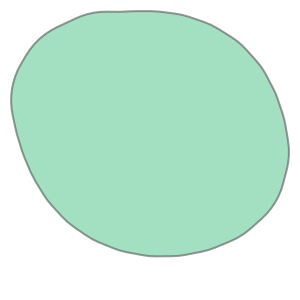

In [144]:
buffered_poly_5x.iloc[0].geometry

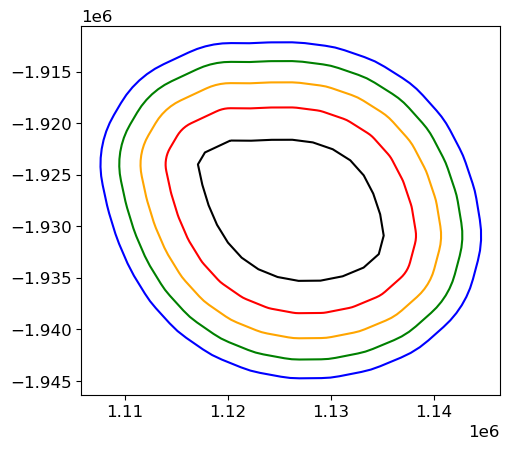

In [104]:
fig, ax = plt.subplots()
SiegfriedFricker2018_S09outlines[SiegfriedFricker2018_S09outlines['name'] == ROI_name].geometry.boundary.plot(ax=ax, color='k')
buffered_poly_2x.boundary.plot(ax=ax, color='red')
buffered_poly_3x.boundary.plot(ax=ax, color='orange')
buffered_poly_4x.boundary.plot(ax=ax, color='green')
buffered_poly_5x.boundary.plot(ax=ax, color='blue')
plt.show()

In [105]:
create_folder(OUTPUT_DIR + '/{}'.format(ROI_name))

Folder '/home/jovyan/1_outlines_candidates/output/Fig2_lake_reexamination.ipynb/Ninnis_1' already exists.


In [108]:
# Select first listed lake from Smith and others, 2009 inventory 
# collated in Siegfried & Fricker, 2018
lake_gdf=SiegfriedFricker2018_S09outlines.iloc[0:1]

In [124]:
# Plot height change time series
height_change_time_series(lake_gdf, CS2_Smith2017, ATL15_dh)

Folder '/home/jovyan/1_outlines_candidates/output/Fig2_lake_reexamination.ipynb/height_change_time_series' already exists.
Folder '/home/jovyan/1_outlines_candidates/output/Fig2_lake_reexamination.ipynb/height_change_time_series/Bindschadler_1' already exists.
Now creating/saving plots...


In [119]:
SiegfriedFricker2018_SF18outlines

,name,geometry,area (m^2),perimeter (m),cite
23,ConwaySubglacialLake,"POLYGON ((-312825.002 -511425.001, -312699.997...",2.669973e+08,93967.290533,"Fricker & Scambos, 2009, J. Glac., doi:10.3189..."
25,Cook_E2,"POLYGON ((765592.392 -1714713.856, 765682.174 ...",2.680933e+08,127109.861123,"McMillan and others, 2013, GRL, doi:10.1002/gr..."
41,EngelhardtSubglacialLake,"POLYGON ((-271824.984 -628674.969, -271699.995...",3.577632e+08,122225.431584,"Fricker & Scambos, 2009, J. Glac., doi:10.3189..."
65,KT1,"POLYGON ((-556189.687 -681400.000, -556000.000...",4.549884e+07,31575.761008,"Kim and others, 2016, TC, doi:10.5194/tc-10-29..."
66,KT2,"POLYGON ((-441794.803 -712600.000, -441600.000...",3.315274e+07,32351.217554,"Kim and others, 2016, TC, doi:10.5194/tc-10-29..."
67,KT3,"POLYGON ((-399646.273 -716600.000, -399600.000...",4.055444e+07,33296.288468,"Kim and others, 2016, TC, doi:10.5194/tc-10-29..."
80,Lake10,"POLYGON ((-227949.981 -569549.997, -228075.000...",2.587121e+07,21525.193986,"Fricker & Scambos, 2009, J. Glac., doi:10.3189..."
81,Lake12,"POLYGON ((-224449.970 -604674.969, -224449.970...",6.689842e+07,31339.673859,"Fricker & Scambos, 2009, J. Glac., doi:10.3189..."
82,Lake78,"MULTIPOLYGON (((-257325.009 -525800.047, -2571...",2.330027e+08,128470.660267,"Carter and others, 2013, J. Glac., doi:10.3189..."
85,Mac1,"POLYGON ((-629350.010 -889125.010, -629325.010...",1.563754e+08,64534.427498,"Fricker and others, 2010, J. Glac., doi:10.318..."


In [ ]:
gdf = find_evolving_outlines(ROI_name, buffered_poly_2.geometry, 0.3, CS2_Smith2017, ATL15_dh)

0
2010-07-02T15:00:00.000000000
2010-10-01T22:30:00.000000000
1
2010-10-01T22:30:00.000000000
2011-01-01T00:00:00.000000000


In [163]:
len(midcyc_dates)

51

In [169]:
cyc_start_dates

[numpy.datetime64('2010-07-02T15:00:00.000000000'),
 numpy.datetime64('2010-10-01T22:30:00.000000000'),
 numpy.datetime64('2011-01-01T00:00:00.000000000'),
 numpy.datetime64('2011-04-02T07:30:00.000000000'),
 numpy.datetime64('2011-07-02T15:00:00.000000000'),
 numpy.datetime64('2011-10-01T22:30:00.000000000'),
 numpy.datetime64('2012-01-01T00:00:00.000000000'),
 numpy.datetime64('2012-04-01T07:30:00.000000000'),
 numpy.datetime64('2012-07-01T15:00:00.000000000'),
 numpy.datetime64('2012-09-30T22:30:00.000000000'),
 numpy.datetime64('2013-01-01T00:00:00.000000000'),
 numpy.datetime64('2013-04-02T07:30:00.000000000'),
 numpy.datetime64('2013-07-02T15:00:00.000000000'),
 numpy.datetime64('2013-10-01T22:30:00.000000000'),
 numpy.datetime64('2014-01-01T00:00:00.000000000'),
 numpy.datetime64('2014-04-02T07:30:00.000000000'),
 numpy.datetime64('2014-07-02T15:00:00.000000000'),
 numpy.datetime64('2014-10-01T22:30:00.000000000'),
 numpy.datetime64('2015-01-01T00:00:00.000000000'),
 numpy.datet

In [ ]:
# Select one lake to demonstrate process
ROI_name = 'Slessor_2_3_23'

In [ ]:
# Store polygons that are different delineations of the same lake(s)
polygon1 = Smith2009_outlines[Smith2009_outlines['Name'] == 'Slessor_2']['geometry_2d']
polygon2 = Smith2009_outlines[Smith2009_outlines['Name'] == 'Slessor_3']['geometry_2d']
polygon3 = SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == 'Slessor_23']['geometry']

In [ ]:
# Combine polygons into unififed polygon to create limit of evolving outline search
polygons = [polygon1, polygon2, polygon3]
union_polygon = unify_polygons(polygons)

In [ ]:
# Create buffered polygon
# buffered_poly = muliple_area_buffer(ROI.geometry.values, 3)
buffered_poly = muliple_area_buffer(union_polygon, 3)

In [ ]:
buffered_poly_2 = muliple_area_buffer(union_polygon, 6)

In [ ]:
fig, ax = plt.subplots()
SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == 'Slessor_23'].boundary.plot(ax=ax)
Smith2009_outlines[Smith2009_outlines['Name'] == 'Slessor_2']['geometry_2d'].boundary.plot(ax=ax)
Smith2009_outlines[Smith2009_outlines['Name'] == 'Slessor_3']['geometry_2d'].boundary.plot(ax=ax)
buffered_poly.boundary.plot(ax=ax, color='red')
plt.show()

In [ ]:
create_folder(OUTPUT_DIR + '/{}'.format(ROI_name))

In [ ]:
CS2_Smith2017

In [ ]:
CS2_Smith2017['count'][0,:,:].plot()

In [ ]:
CS2_Smith2017.h[0,:,:].plot()

In [ ]:
CS2_Smith2017.delta_h[0,:,:].plot()

In [ ]:
CS2_Smith2017.delta_h_ATL14[0,:,:].plot()

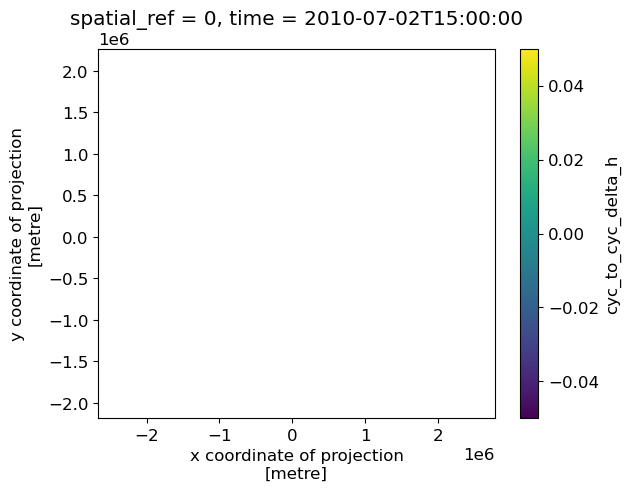

In [149]:
CS2_Smith2017.cyc_to_cyc_delta_h[0,:,:].plot()

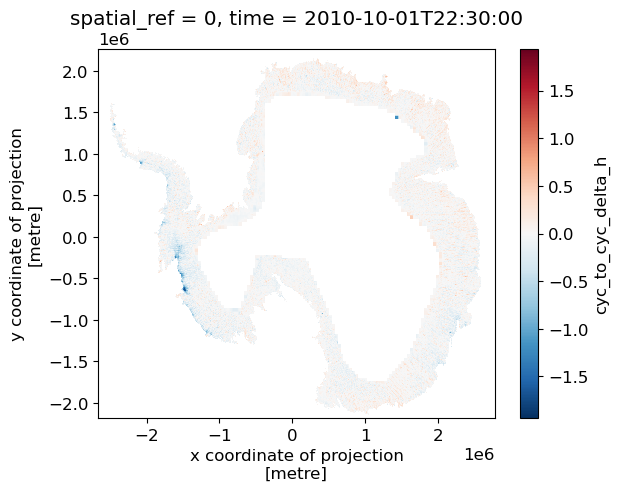

In [150]:
CS2_Smith2017.cyc_to_cyc_delta_h[1,:,:].plot()

In [156]:
np.any(~np.isnan(CS2_Smith2017.cyc_to_cyc_delta_h[0,:,:]))

<xarray.DataArray 'cyc_to_cyc_delta_h' ()>
array(False)
Coordinates:
    spatial_ref  int64 0
    time         datetime64[ns] 2010-07-02T15:00:00

In [157]:
np.any(~np.isnan(CS2_Smith2017.cyc_to_cyc_delta_h[1,:,:]))

<xarray.DataArray 'cyc_to_cyc_delta_h' ()>
array(True)
Coordinates:
    spatial_ref  int64 0
    time         datetime64[ns] 2010-10-01T22:30:00

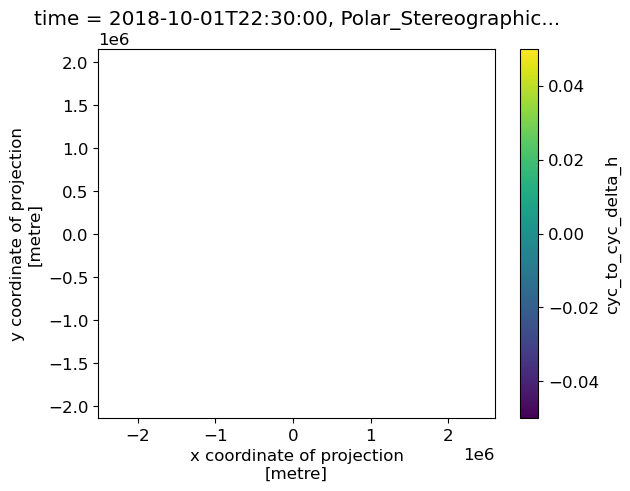

In [79]:
ATL15_dh.cyc_to_cyc_delta_h[0,:,:].plot()

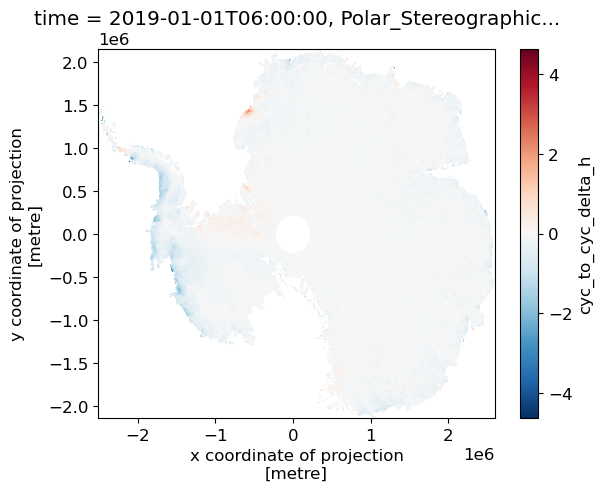

In [80]:
ATL15_dh.cyc_to_cyc_delta_h[1,:,:].plot()

In [88]:
ATL15_dh.time[0].values

numpy.datetime64('2018-10-01T22:30:00.000000000')

In [123]:
ATL15_dh.time[1].values

numpy.datetime64('2019-01-01T06:00:00.000000000')

In [97]:
CS2_Smith2017.time[0].values

numpy.datetime64('2010-07-02T15:00:00.000000000')

In [ ]:
gdf = find_evolving_outlines(ROI_name, buffered_poly_2.geometry, 0.3, CS2_Smith2017, ATL15_dh)

In [ ]:
# Check which evolving outline polygons touch or cross the evolving outline search limit polygon
# Check if geometries in left_gdf touches or crosses the boundary of the right_geom
within = gpd.sjoin(gdf, buffered_poly, predicate='within')
overlaps = gpd.sjoin(gdf, buffered_poly, predicate='overlaps')

# Find percentage intersecting
len(within) / (len(within) + len(overlaps))

In [ ]:
fig, ax = plt.subplots()
gdf.boundary.plot(ax=ax, color='orange')
buffered_poly.boundary.plot(ax=ax, color='red')
buffered_poly_2.boundary.plot(ax=ax, color='black')
within.boundary.plot(ax=ax, color='yellow')
overlaps.boundary.plot(ax=ax, color='darkred')
plt.show()

In [ ]:
union_polygon

In [ ]:
buffered_poly_2

In [ ]:
union_polygon.centroid

In [ ]:
buffered_poly.centroid

In [ ]:
buffered_poly_2.centroid

In [ ]:
buffered_poly_2.centroid.values

In [ ]:
buffered_poly_2.centroid.values[0]

In [ ]:
print(type(buffered_poly_2))
print(type(buffered_poly_2.centroid))
print(type(buffered_poly_2.centroid.values))
print(type(buffered_poly_2.centroid.values[0]))

# Repeat on all previously outlined lakes

In [ ]:
SiegfriedFricker2018_S09outlines

In [ ]:
SiegfriedFricker2018_non_intersections

In [ ]:
# create list of S09 lakes redelineated in SF18
S09_SF18_redefined_lake_names = [   
    ['Cook_E2', 'Cook_E2'],
    ['KambTrunk_1', 'KT1'],
    ['Macayeal_1', 'Mac1'],
    ['Macayeal_2', 'Mac2'],
    ['Mercer_1', 'Lake78'],
    ['Mercer_2', 'MercerSubglacialLake'],
    ['Recovery_3', 'Rec2'],
    ['Recovery_4', 'Rec3'],
    ['Recovery_5', 'Rec4'], 
    ['Recovery_6', 'Rec5'],
    ['Recovery_7', 'Rec6'],
    ['Recovery_9', 'Rec8'],
    ['Recovery_10', 'Rec9'],
    ['Recovery_11', 'Rec10'],     
    ['Whillans_1', 'EngelhardtSubglacialLake'],            
    ['Whillans_2a', 'Lake12'],
    ['Whillans_2b', 'Lake10'],
    ['Whillans_3', 'WhillansSubglacialLake'],
    ['Whillans_4', 'ConwaySubglacialLake'],
    ['Whillans_5', 'UpperSubglacialLakeConway'],
    # Two S09 lakes converted to one SF18 lake
    ['Slessor_2', 'Slessor_3', 'Slessor_23'],
    ['Recovery_1', 'Recovery_2', 'Rec1'],
    # One S09 lake converted to two SF18 lakes
    ['Macayeal_3', 'Mac4', 'Mac5']
]

In [ ]:
Smith2009_outlines[Smith2009_outlines['Name'] == 'Cook_E2']['geometry_2d'],
SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == 'Cook_E2']['geometry']],

# Fig. S1

In [ ]:
ROI_poly = buffered_poly
print(type(buffered_poly))
print(type(ROI_poly))

In [ ]:
ROI_poly = buffered_poly
dataset1 = CS2_dh
dataset2 = ATL15_dh

# Clipping datasets
dataset1_clipped = dataset1.rio.clip(ROI_poly, dataset1.rio.crs)
dataset2_clipped = dataset2.rio.clip(ROI_poly, dataset2.rio.crs)

# Extract min and max of x and y for dataset1
min_x1 = dataset1_clipped.x.min().item()
max_x1 = dataset1_clipped.x.max().item()
min_y1 = dataset1_clipped.y.min().item()
max_y1 = dataset1_clipped.y.max().item()

# Extract min and max of x and y for dataset2
min_x2 = dataset2_clipped.x.min().item()
max_x2 = dataset2_clipped.x.max().item()
min_y2 = dataset2_clipped.y.min().item()
max_y2 = dataset2_clipped.y.max().item()

# Check if the coordinates match
if min_x1 != min_x2 or max_x1 != max_x2 or min_y1 != min_y2 or max_y1 != max_y2:
    raise ValueError("Dataset1 and Dataset2 do not have matching x, y min, max coordinates")

# Establish x_min, x_max, y_min, y_max, 
x_min = min_x1
x_max = max_x1
y_min = min_y1
y_max = max_y1

# Subsetting datasets
# Subset datasets to region of interest for plotting
buffer = 4000
mask_x = (dataset1.x >= x_min-buffer) & (dataset1.x <= x_max+buffer)
mask_y = (dataset1.y >= y_min-buffer) & (dataset1.y <= y_max+buffer)
dataset1_subset = dataset1.where(mask_x & mask_y, drop=True)
mask_x = (dataset2.x >= x_min-buffer) & (dataset2.x <= x_max+buffer)
mask_y = (dataset2.y >= y_min-buffer) & (dataset2.y <= y_max+buffer)
dataset2_subset = dataset2.where(mask_x & mask_y, drop=True)
mask_x = (moa_highres_da.x >= x_min-buffer) & (moa_highres_da.x <= x_max+buffer)
mask_y = (moa_highres_da.y >= y_min-buffer) & (moa_highres_da.y <= y_max+buffer)
moa_highres_da_subset = moa_highres_da.where(mask_x & mask_y, drop=True)

In [ ]:
# Modify find contours function to achieve something like less than 5% of contours intersecting with buffer
# gdf = find_evolving_outlines(ROI['name'].values[0], buffered_poly, 0.5, CS2_dh, ATL15_dh)
# gdf = find_evolving_outlines(ROI['name'].values[0], buffered_poly, 0.5, CS2_dh, ATL15_dh)
gdf = find_evolving_outlines('Slessor_2_3_23', buffered_poly, 0.5, CS2_dh, ATL15_dh)

In [ ]:
# Remove off-lake outlines (find function in lake areas notebook)
gdf_subset = remove_outlier_polygon(gdf, 'y', 'max')

In [ ]:
gdf_subset = remove_outlier_polygon(gdf_subset, 'y', 'max')

In [ ]:
gdf_subset = remove_outlier_polygon(gdf_subset, 'y', 'max')

In [ ]:
gdf_subset = remove_outlier_polygon(gdf_subset, 'y', 'min')

In [ ]:
gdf_subset = remove_outlier_polygon(gdf_subset, 'y', 'min')

In [ ]:
# TODO
# Try other lakes

# Plot Fig. 2
fig, ax = plt.subplots(3,1, sharex=True, figsize=(5.5,16.5))


# Panel A - Plot uplift filling event
# Specify the time value you want to plot
specified_date = datetime.date(2010, 8, 17)
gdf_subset[(gdf_subset['date'] == specified_date) & (gdf_subset['dh (m)'] > 0)].boundary.plot(ax=ax[0], color='blue')
gdf_subset[(gdf_subset['date'] == specified_date) & (gdf_subset['dh (m)'] < 0)].boundary.plot(ax=ax[0], color='red')

# Calculate the absolute difference between each time in the dataset and the specified time
time_diff = np.abs(midcyc_dates - np.datetime64(specified_date))
# Find the index of the minimum difference
nearest_time_index = time_diff.argmin().item()
if nearest_time_index <= 32:
    dhdt = dataset1_subset.cyc_to_cyc_delta_h[nearest_time_index,:,:]
elif nearest_time_index > 32:
    # Subtract 33 from idx to start over with new dataset
    dhdt = dataset2_subset.cyc_to_cyc_delta_h[(nearest_time_index-33),:,:]

# Plot gridded height change data
divnorm=colors.TwoSlopeNorm(vmin=-1.5, vcenter=0., vmax=1.5)  
img = ax[0].imshow(dhdt, extent=[x_min-buffer, x_max+buffer, y_min-buffer, y_max+buffer], origin='upper', cmap='coolwarm_r', 
                   # norm=colors.CenteredNorm(),
                   norm=divnorm)

# Plot buffered polygon showing extent of evolving outline search
ROI_color = 'magenta'
gpd.GeoSeries(buffered_poly).boundary.plot(ax=ax[0], color=ROI_color)

# Create an axes on the right side of ax1 for the colorbar
cax = fig.add_axes([ax[0].get_position().x1 + 0.15, ax[0].get_position().y0 - 0.092, 0.03, ax[0].get_position().height])
fig.colorbar(img, cax=cax).set_label('height change [m]', size=12)

# Annotate time slice
ax[0].annotate('height change: {} to {}'.format(datetime64_to_fractional_year(cyc_start_dates[nearest_time_index]),
    datetime64_to_fractional_year(cyc_end_dates[nearest_time_index])), 
    xy=(-421e3,1009e3), xycoords='data', fontsize=14)


# Panel B - Plot subsidence draining event
# specified_date = datetime.date(2021, 2, 15)
specified_date = datetime.date(2020, 2, 16)
# specified_date = datetime.date(2015, 8, 17)

gdf_subset[(gdf_subset['date'] == specified_date) & (gdf_subset['dh (m)'] > 0)].boundary.plot(ax=ax[1], color='blue')
gdf_subset[(gdf_subset['date'] == specified_date) & (gdf_subset['dh (m)'] < 0)].boundary.plot(ax=ax[1], color='red')

# Calculate the absolute difference between each time in the dataset and the specified time
time_diff = np.abs(midcyc_dates - np.datetime64(specified_date))
# Find the index of the minimum difference
nearest_time_index = time_diff.argmin().item()
if nearest_time_index <= 32:
    dhdt = dataset1_subset.delta_h[nearest_time_index+1,:,:]-dataset1_subset.delta_h[nearest_time_index,:,:]
elif nearest_time_index > 32:
    # Subtract 33 from idx to start over with new dataset
    dhdt = dataset2_subset.delta_h[(nearest_time_index-33)+1,:,:]-dataset2_subset.delta_h[(nearest_time_index-33),:,:]

# Plot gridded height change data
img = ax[1].imshow(dhdt, extent=[x_min-buffer, x_max+buffer, y_min-buffer, y_max+buffer], origin='lower', cmap='coolwarm_r', 
                   # norm=colors.CenteredNorm(),
                   norm=divnorm)
gpd.GeoSeries(buffered_poly).boundary.plot(ax=ax[1], color=ROI_color)

ax[1].annotate('height change: {} to {}'.format(datetime64_to_fractional_year(cyc_start_dates[nearest_time_index]),
    datetime64_to_fractional_year(cyc_end_dates[nearest_time_index])), 
    xy=(-421e3,1009e3), xycoords='data', fontsize=14)


# Panel C - Plot outlines in aggregate vs. two past static delineations
# Plot MOA imagery  
ax[2].imshow(moa_highres_da_subset[0,:,:], cmap="gray", clim=[14000, 17000], extent=[x_min-buffer, x_max+buffer, y_min-buffer, y_max+buffer])

# Pick colormap and make continuous cmap discrete for evolving outlines
colormap = 'plasma'
continuous_cmap = matplotlib.colormaps[colormap]
discrete_cmap = colors.ListedColormap(continuous_cmap(np.linspace(0, 1, len(midcyc_dates)-1)))

# Norm to time variable
norm = plt.Normalize(mdates.date2num(midcyc_dates[0]), 
                     mdates.date2num(midcyc_dates[-1]))

# Use for loop to store each time slice as line segment to use in legend
# And plot each outline in the geopandas dataframe and color by date
lines = []  # list of lines to be used for the legend
for idx, dt in enumerate(midcyc_dates, 0):
    x = 1; y = 1
    line, = ax[2].plot(x, y, color=discrete_cmap(norm(mdates.date2num(midcyc_dates[idx]))), linewidth=3)
    lines.append(line)
    
    # Filter rows that match the current time slice
    gdf_subset_dt = gdf_subset[gdf_subset['datetime'] == dt]

    # Plotting the subset
    gdf_subset_dt.plot(ax=ax[2], edgecolor=discrete_cmap(norm(mdates.date2num(midcyc_dates[idx]))), facecolor='none')

    
# All panels
# Label axes and set limits
ax[2].set_xlabel('x [km]', size=16)
ax[1].set_ylabel('y [km]', size=16)

# ax[0].annotate('A', xy=(-425e3,1049e3), xycoords='data', fontsize=30)
# ax[1].annotate('B', xy=(-425e3,1049e3), xycoords='data', fontsize=30)
# ax[2].annotate('C', xy=(-425e3,1049e3), xycoords='data', fontsize=30)
ax[0].annotate('A', xy=(0.02, 0.9), xycoords='axes fraction', fontsize=30)
ax[1].annotate('B', xy=(0.02, 0.9), xycoords='axes fraction', fontsize=30)
ax[2].annotate('C', xy=(0.02, 0.9), xycoords='axes fraction', fontsize=30)

# Create lines for legend
S09_color = 'lightseagreen'
SF18_color = 'teal'
Smith2009 = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 2)), linewidth=3)
SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color=SF18_color, linestyle=(0, (1, 1)), linewidth=3)
ROI = plt.Line2D((0, 1), (0, 0), color=ROI_color, linestyle='solid', linewidth=3)
uplift = plt.Line2D((0, 1), (0, 0), color='blue', linewidth=3)
subsidence = plt.Line2D((0, 1), (0, 0), color='red', linewidth=3)

# Create legends
ax[0].legend([Smith2009, SiegfriedFricker2018, ROI, uplift], 
           ['static outline [10]',
            'static outline [13]', 
            # 'evolving outline ({} m threshold)'.format(threshold)], 
            'evolving outline search limit [this study]',
            'evolving outline - uplift [this study]'], 
             loc='upper right') 

ax[1].legend([subsidence],
           ['evolving outline - subsidence [this study]'], 
             loc='upper right')

legend = ax[2].legend([tuple(lines)], ['evolving outlines [this study]'],
    handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
    loc='upper center')
legend.get_frame().set_linewidth(0.0)
ax[2].patch.set_alpha(1)

# Create colorbar 
m = plt.cm.ScalarMappable(cmap=discrete_cmap)
m.set_array(np.array([datetime64_to_fractional_year(date) for date in midcyc_dates[0:]]))
cax = inset_axes(ax[2],
                 width="100%",
                 height="2.5%",
                 loc=3,
                 bbox_to_anchor=[0,-0.14,1,1],
                 bbox_transform=ax[2].transAxes,
                 borderpad=0,
                 )
cbar=fig.colorbar(m, ticks=np.array([2010,2012,2014,2016,2018,2020,2022]), 
             cax=cax, orientation='horizontal').set_label('evolving outline year', size=15)

# Plot inset map
axIns = ax[0].inset_axes([0.01, 0.01, 0.3, 0.3]) # [left, bottom, width, height] (fractional axes coordinates)
axIns.set_aspect('equal')
moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
axIns.axis('off')
# # Plot black rectangle to indicate location
# rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='k', zorder=3)
# axIns.add_artist(rect)
# Plot red star to indicate location
axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
    linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)

# # Add annotation to the opposite side of the colorbar
# cbar.ax.text(1.1, 0.5, 'CryoSat-2 era', va='center', ha='left', transform=cbar.ax.transAxes)

for i in ax: 
    Smith2009_outlines.boundary.plot(ax=i, edgecolor=S09_color, facecolor='none', linestyle=(0, (1, 2)), linewidth=3, alpha=1, zorder=0)
    SiegfriedFricker2018_SF18outlines.boundary.plot(ax=i, edgecolor=SF18_color, facecolor='none', linestyle=(0, (1, 1)), linewidth=3, alpha=1, zorder=0)
    
    # Change polar stereographic m to km
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    i.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    i.yaxis.set_major_formatter(ticks_y)
    
    # i.set(xlim=(x_min-buffer, x_max+buffer), ylim=(y_min-buffer, y_max+buffer))   
    i.set(xlim=(x_min-buffer, x_max+buffer), ylim=(y_min-buffer, y_max+buffer))   

plt.tight_layout()

plt.show()